In [1]:
import os
from pathlib import Path
from lxml import etree


import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd

with open('.env') as f:
    openai.api_key = f.read().strip().split('=')[1]


In [14]:
UDHR19 = pd.read_csv('data/language_id.csv').set_index('code')[['name', 'text']]
UDHR19.sample(20)

,name,text
code,,
ces,Czech,Každý má právo na svobodu přesvědčení a projev...
kmr,"Kurdish, Northern",Herkes mafê azadiya fikr û îfade heye; mafê ji...
kir,Kirghiz,Ар бир адам ынанымда болуу эркиндигине жана ан...
cos,Corsican,Hà dirittu ogni individuu à a libertà d’upinio...
hin,Hindi,प्रत्येक व्यक्ति को विचार और उसकी अभिव्यक्ति क...
heb,Hebrew,"כל אדם זכאי לחירות הדעה והבטוי, לרבות החירות ל..."
quc,"K'iche', Central","Ronojel winaq ya'tal chech kub'ij, kuq'alajisa..."
kor,Korean,모든 사람은 의견의 자유와 표현의 자유에 대한 권리를 가진다. 이러한 권리는 간섭없...
hrv,Croatian,Svatko ima pravo na slobodu mišljenja i izraža...


In [43]:
batch_size = 10

embeddings = []

for s in range(0, len(UDHR19.text.values), batch_size):
    batch = list(UDHR19.text.values[s: s + batch_size])
    print(s, s + batch_size, UDHR19.index[s: s + batch_size])
    response = openai.Embedding.create(input=batch, model="text-embedding-ada-002")
    embeddings.append(np.asarray([e.embedding for e in response['data']]))

embeddings = np.vstack(embeddings)

np.savetxt('data/udhr19.emb', embeddings)


0 10 Index(['afr', 'als', 'arb', 'azj_latn', 'bel', 'ben', 'bre', 'bul', 'cat',
       'ceb'],
      dtype='object', name='code')
10 20 Index(['ces', 'cmn_hans', 'cmn_hant', 'cos', 'cym', 'dan', 'deu_1996',
       'ell_monotonic', 'eng', 'epo'],
      dtype='object', name='code')
20 30 Index(['est', 'eus', 'fao', 'fin', 'fra', 'fri', 'fur', 'gle', 'glg',
       'hat_kreyol'],
      dtype='object', name='code')
30 40 Index(['hau_3', 'haw', 'heb', 'hin', 'hrv', 'hsb', 'hun', 'hye', 'ibo', 'ina'], dtype='object', name='code')
40 50 Index(['ind', 'isl', 'ita', 'jav', 'jpn', 'kat', 'kaz', 'kbd', 'khk', 'kir'], dtype='object', name='code')
50 60 Index(['kjh', 'kmr', 'kor', 'lad', 'lat', 'lav', 'lin', 'lit', 'ltz', 'mar'], dtype='object', name='code')
60 70 Index(['mkd', 'mxv', 'nav', 'nds', 'nhn', 'nld', 'nno', 'nob', 'pan', 'pap'], dtype='object', name='code')
70 80 Index(['pcm', 'pes_1', 'pol', 'por_BR', 'por_PT', 'quc', 'rmy', 'roh',
       'ron_2006', 'run'],
      dtype='object', name='

In [51]:
embeddings.shape

(109, 1536)

In [140]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

embedding_transform = pca.fit_transform(embeddings)

print(pca.explained_variance_ratio_)

embedding_transform.shape


[0.15944851 0.06002236 0.04474356 0.03518539 0.03129205 0.0275011
 0.0260766  0.02229087 0.02028801 0.01960933]


(109, 10)

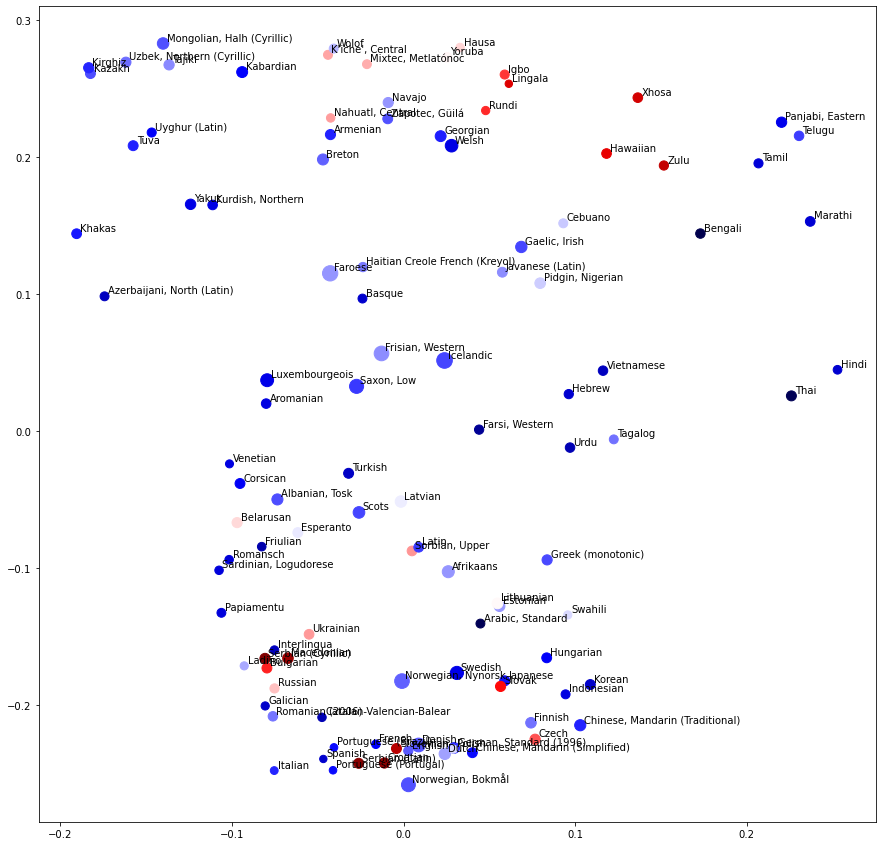

In [146]:
fig, ax = plt.subplots(figsize=(15,15))

# Dimension 0 - the prestige dimension?
# Dimension 2 - the 
# Dimension 4 - the Germanic vs. Romance dimension
dim1, dim2, dim3, dim4 = 2, 0, 4, 3


ax.scatter(*embedding_transform.T[[dim1, dim2]], s=(10 + 20 * embedding_transform.T[dim3])**2, c=embedding_transform.T[dim4], cmap='seismic')

#fig.colorbar(mpl.cm.ScalarMappable(norm=None, cmap='Spectral'), ax=ax)


for idx, name in enumerate(UDHR19.name.values):
    ax.annotate(name, embedding_transform[idx][[dim1, dim2]] + (0.002, 0.002))